<a href="https://colab.research.google.com/github/karishmashaik549/FMML2024/blob/main/Module_9Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2025-04-18 13:09:27--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.238.238.114, 18.238.238.104, 18.238.238.23, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.238.238.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2025-04-18 13:09:27 (304 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes

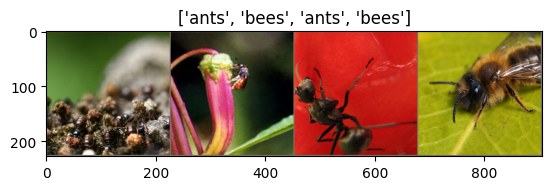

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.4939 Acc: 0.7254

Epoch 1/4
----------
Loss: 0.5393 Acc: 0.7582

Epoch 2/4
----------
Loss: 0.5502 Acc: 0.7746

Epoch 3/4
----------
Loss: 0.5998 Acc: 0.7705

Epoch 4/4
----------
Loss: 0.6291 Acc: 0.7541



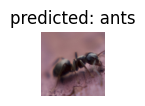

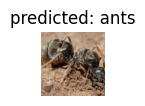

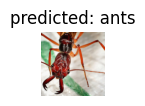

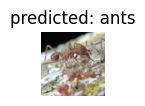

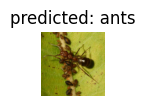

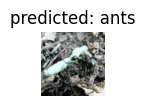

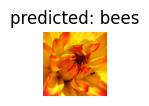

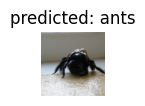

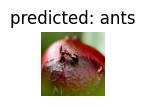

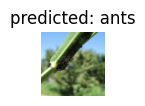

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


ANSWERS
-------------

1) What is the significance of using data augmentations like resize, crop etc on training data?
-------
Answer)


Using data augmentations like resize, crop, flip, rotate, etc., on training data is significant for several key reasons:

1. Improves Model Generalization
Augmentations create variations of the training data, helping the model learn to generalize better to unseen data. For example, cropping different parts of an image or flipping it horizontally teaches the model that the object can appear in different positions or orientations.

2. Reduces Overfitting
By increasing the diversity of the training dataset without actually collecting more data, augmentations help prevent the model from memorizing the training data (overfitting), thus performing better on validation/test sets.

3. Simulates Real-World Scenarios
Resize, crop, and similar transformations mimic real-world variations such as different camera angles, distances, or slight misalignments. This makes the model more robust in practical applications.

4. Effective with Limited Data
When you don’t have a lot of training data, augmentations can synthetically increase dataset size, which can significantly improve model performance.

Would you like an example showing how a specific augmentation like cropping or resizing affects training?

100%|██████████| 170M/170M [00:05<00:00, 34.0MB/s]


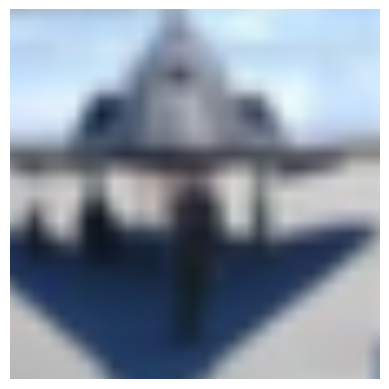

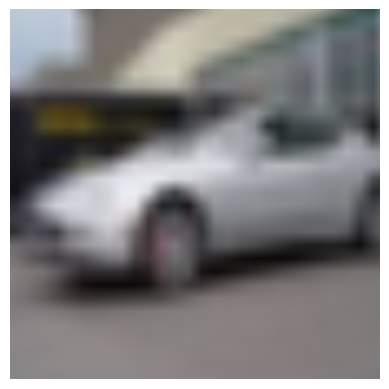

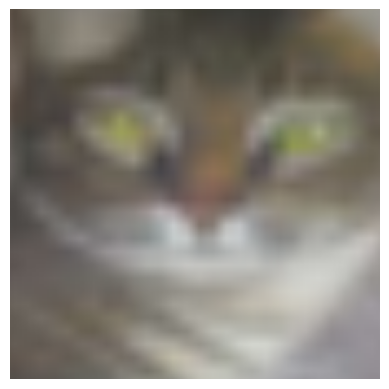

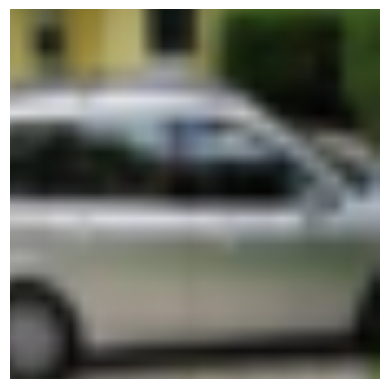

In [11]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transform with resize and random crop
transform = transforms.Compose([
    transforms.Resize((256, 256)),             # Resize the image to 256x256
    transforms.RandomCrop((224, 224)),         # Then randomly crop a 224x224 patch
    transforms.ToTensor()                      # Convert to tensor
])

# Load a sample dataset (e.g., CIFAR10)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Visualize a few augmented images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert tensors to numpy and plot
def imshow(img):
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for i in range(4):
    imshow(images[i])

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)
--------------
Answer)



When you don't use a pretrained ResNet model (i.e., set pretrained=False), you start with random weights instead of weights learned from training on ImageNet. Here's what typically happens:

Performance Impact (without pretrained weights):

Lower accuracy: The model struggles to learn good feature representations from scratch, especially on small datasets like CIFAR-10 or custom datasets with limited samples.
Slower convergence: Training takes longer, as the model has to learn everything from the ground up.
Higher chance of overfitting: Especially if the dataset is small and lacks diversity.
Worse generalization: The model might perform well on training data but poorly on validation/test data.

Example: ResNet18 on CIFAR-10
These are just rough benchmarks—actual results depend on hyperparameters, training epochs, and data size.

If you want, I can show you the PyTorch code where you switch between pretrained and non-pretrained ResNet. Want to see that?

In [12]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load ResNet18 model (change pretrained to True or False)
model = resnet18(pretrained=False)  # Set to True to use pretrained weights

# Modify final layer for 10 output classes (CIFAR-10)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate on test set
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/5], Loss: 1.0117
Epoch [2/5], Loss: 0.8812
Epoch [3/5], Loss: 0.5240
Epoch [4/5], Loss: 1.1069
Epoch [5/5], Loss: 0.4190
Test Accuracy: 80.49%


3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?
--------------
Answer)



Great question!

If the ResNet model was pretrained on a dataset significantly different from your target data (e.g., medical images or satellite images, but you're training on ants vs bees), then:

You might still get decent performance — but with caveats:
Why you can still benefit:

Low-level features like edges, textures, and shapes learned by early layers are often transferable across domains.
These general features can give your model a "head start" during training, especially if your dataset is small.
Fine-tuning the later layers helps the model adapt to your specific task.

Why performance might suffer:

If the source dataset (for pretraining) is very different in structure, resolution, or content, higher-level features (like object parts or patterns) may not transfer well.
The more your target domain differs from the source, the less helpful pretrained weights become—sometimes they can even hurt performance slightly if not fine-tuned properly.

So, what's the best approach?

Use the pretrained model, but:

Freeze the early layers (optional), and
Fine-tune the deeper layers or the entire model using your ants vs bees data.



Would you like code showing how to fine-tune a pretrained model for ants vs bees?

In [13]:

import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = datasets.ImageFolder('./hymenoptera_data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: ants, bees
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train (short/simple)
for epoch in range(3):
    model.train()
    correct = total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%")

Epoch 1, Accuracy: 79.92%
Epoch 2, Accuracy: 86.89%
Epoch 3, Accuracy: 85.25%
